<a href="https://colab.research.google.com/github/sjunc/AI-Library/blob/main/class/W05_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05주차 실습 RNN

## 넷플릭스 주가 예측

시작가, 최고가, 최저가, 총, 마지막 가격

In [3]:
import pandas as pd

data = pd.read_csv("NetflixStock.csv")  # 데이터 파일을 읽어옴
data.head()  # 5개의 데이터를 표시

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [4]:
data.info() #결측치 여부 등 파악

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


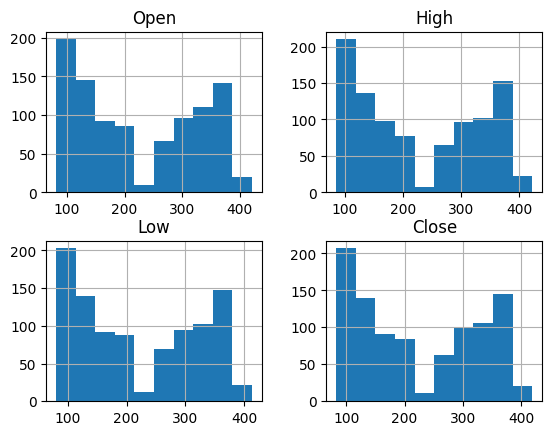

In [5]:
import matplotlib.pyplot as plt

data_used = data.iloc[:, 1:4] # 개장가, 최고가, 최저가 추가
data_used["Close"] = data["Close"] # 종가 추가
hist = data_used.hist()
plt.show()

In [6]:
import numpy as np
from torch.utils.data.dataset import Dataset

# Netfilx 데이터 셋 클래스 구현

class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv("NetflixStock.csv")    # 데이터 읽기

        #입력 데이터 정규화 (0 ~ 1 사이로 스케일링)
        self.data = self.csv.iloc[:, 1:4].values
        self.data = (self.data - np.min(self.data, axis=0)) / (np.max(self.data, axis=0) - np.min(self.data, axis=0))

        #종가 데이터 정규화
        self.label = data["Close"].values # 예측할 값은 종가
        self.label = (self.label - np.min(self.label)) / (np.max(self.label) - np.min(self.label))

    #데이터셋 크기 반환 함수.
    #학습 데이터가 30일씩 슬라이싱되므로, 전체 길이에서 30을 뺀만큼만 유효한 샘플로 사용함
    def __len__(self):
        return len(self.data) - 30 #사용 가능한 배치 개수

    #특정 index에 해당하는 샘플 반환하기
    def __getitem__(self, i):
        data = self.data[i:i+30] # 과거 30일치 시계열 데이터 (입력값) :: 즉, 30일씩 슬라이싱하여 입력값으로 사용할 것이다.
        label = self.label[i+30] # 그 다음 날 종가 (예측값) #! 그 다음 30일동안의 종가가 아님!!, 단일 시점을 예측하는 것임.

        return data, label



In [7]:
#RNN 클래스 정의
import torch
import torch.nn as nn

#RNN 모델 정의
class RNN(nn.Module):

   #모델에서 사용할 레이어 층들을 정의
   def __init__(self):
       super(RNN, self).__init__()


       self.rnn1 = nn.RNN(input_size=3, hidden_size=8, num_layers=5,
                         batch_first=True)  #RNN층의 정의
       self.rnn2 = nn.RNN(input_size=3, hidden_size=8, num_layers=5,
                         batch_first=True)  #RNN층의 정의
      #(생각해보기) 왜 input_size가 3일까요? open, high와 low 값이기 때문에
      #(알아보기) batch_first는 무슨 역할을 할까?


       #주가를 예측하는 MLP층 정의
       #(생각해보기) 왜 in_features가 240이어야할까?
       self.fc1 = nn.Linear(in_features=240, out_features=64)
       self.fc2 = nn.Linear(in_features=64, out_features=1)
      #(생각해보기) 왜  out_features가 1인가? 하나의 값을 예측해서?

       self.relu = nn.ReLU() # 활성화 함수 정의



  #모델이 실제 입력값을 받아 예측을 수행하는 부
   def forward(self, x, h0):
       x, hn = self.rnn1(x, h0)  #RNN층의 출력 #RNN의 출력값은 (batch, 30(days), 8(hidden states) 모양임

       #MLP층의 입력으로 사용될 수 있도록 모양 변경 -> (batch, 240)으로 펼치기
       x = torch.reshape(x, (x.shape[0], -1))

       # MLP 층을 이용해 종가를 예측
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       # 예측한 종가를 1차원 벡터로 표현
       x = torch.flatten(x)

       return x

In [8]:
#모델, 데이터셋 정의
import tqdm

from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)  # 모델의 정의
dataset = Netflix()  # Netflix 데이터를 로딩하고 전처리한 데이터셋 사용

In [9]:
loader = DataLoader(dataset, batch_size=32)  # 배치 단위로 데이터를 불러올 수 있도록 설정

In [10]:
optim = Adam(params=model.parameters(), lr=0.0001) # Adam 최적화 알고리즘 사용

In [11]:
for epoch in range(200):
   iterator = tqdm.tqdm(loader)#프로그레바 표시
   for data, label in iterator:
       optim.zero_grad()# 기존 gradient 초기화

       # 초기 은닉 상태 정의
       h0 = torch.zeros(5, data.shape[0], 8).to(device)

       # 모델 예측
       pred = model(data.type(torch.FloatTensor).to(device), h0)

       # 평균제곱오차 손실 계산
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화 진행(파라미터 업데이)

       iterator.set_description(f"epoch{epoch} loss:{loss.item()}")# 진행률 표시

torch.save(model.state_dict(), "./rnn.pth")  # 학습한 모델 가중치를 파일로 저장

epoch199 loss:0.0004507516568992287: 100%|██████████| 30/30 [00:00<00:00, 190.03it/s]


In [12]:
import matplotlib.pyplot as plt

loader = DataLoader(dataset, batch_size=1) # 한 개씩 불러와 예측

preds = [] # 예측 결과 저장
total_loss = 0

with torch.no_grad():
   # 모델의 가중치 불러오기
   model.load_state_dict(torch.load("rnn.pth", map_location=device))

   for data, label in loader:
       h0 = torch.zeros(5, data.shape[0], 8).to(device)  #초기 은닉상태 정의

       # 모델의 예측값 출력
       pred = model(data.type(torch.FloatTensor).to(device), h0)
       preds.append(pred.item())  #예측값을 리스트에 추가
       loss = nn.MSELoss()(pred,
                           label.type(torch.FloatTensor).to(device))  # 손실계산
       total_loss += loss/len(loader)  # 전체 손실 평균

total_loss.item()

0.002193528925999999

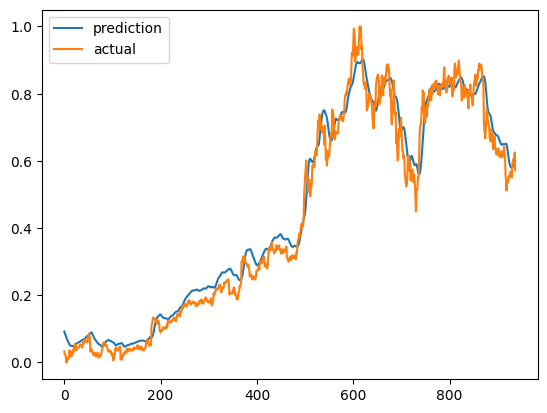

In [16]:
plt.plot(preds, label="prediction")# 예측값 선 그래프
plt.plot( dataset.label[30:], label="actual")# 실제 종가 (30일 이후부터 비교하기 위해서)
plt.legend()
plt.show()


#(생각해보기)x축이 왜 800칸이 넘게 나올까?

#본 실습에서는 학습했던 데이터에서도 prediction을 뽑았지만, 실제로 성능 평가를 하려면 학습/평가 데이터셋을 철저히 나누어 학습 데이터셋으로만 학습하고, 평가 데이터셋과 비교하여야 함.
#(todo) 학습 데이터셋 80%, 예측용(평가용) 데이터셋 20%로 나누어 다시 코드를 개선해 보세요.

## 감정 분석

In [33]:
# RNN 기반 감정 분석 (Many-to-One)

import torch
import torch.nn as nn
import torch.optim as optim

In [34]:
#1. 데이터 준비
train_data = [
    (["오늘", "기분", "좋아"], "긍정"),
    (["정말", "행복한", "하루야"], "긍정"),
    (["이거", "최고야"], "긍정"),
    (["별로야", "다시는", "안", "볼래"], "부정"),
    (["짜증나고", "실망이야"], "부정"),
    (["이건", "진짜", "별로다"], "부정"),
    (["오늘", "하늘이", "맑고", "햇살도", "따뜻해서", "기분", "좋아"], "긍정"),
    (["친구랑", "오랜만에", "재밌게", "놀았어", "행복해"], "긍정"),
    (["생각보다", "결과가", "좋아서", "기뻐"], "긍정"),
    (["선물", "받아서", "기분", "좋아졌어"], "긍정"),
    (["맛있는", "음식", "먹고", "기분", "좋아졌어"], "긍정"),
    (["오늘은", "정말", "행복한", "하루였어"], "긍정"),
    (["시험", "잘", "보고", "칭찬도", "받았어"], "긍정"),
    (["모처럼", "여유롭게", "산책했어", "기분", "좋아"], "긍정"),
    (["예쁜", "꽃을", "보니", "기분이", "좋아졌어"], "긍정"),
    (["걱정하던", "일이", "잘", "풀려서", "다행이야"], "긍정"),
    (["따뜻한", "차", "한잔에", "마음이", "편안해졌어"], "긍정"),
    (["노래", "들으면서", "산책하니까", "기분", "좋았어"], "긍정"),
    (["좋은", "사람들과", "시간", "보내서", "행복했어"], "긍정"),
    (["오랜만에", "일찍", "일어나서", "상쾌했어"], "긍정"),
    (["하늘", "예쁘고", "바람도", "시원해서", "기분", "좋아"], "긍정"),
    (["누군가의", "작은", "배려에", "감동했어"], "긍정"),
    (["좋은", "소식을", "들었어", "기분", "업됐어"], "긍정"),
    (["기대", "안했는데", "결과가", "좋았어"], "긍정"),
    (["계획대로", "모든", "일이", "잘", "됐어"], "긍정"),
    (["오늘", "정말", "뿌듯한", "하루였어"], "긍정"),
    (["오늘", "괜히", "기분", "나쁘고", "짜증났어"], "부정"),
    (["예상", "했던", "것보다", "훨씬", "실망이야"], "부정"),
    (["사소한", "일로", "화를", "내고", "후회했어"], "부정"),
    (["갑자기", "기분", "안", "좋아졌어"], "부정"),
    (["다", "귀찮고", "아무것도", "하기", "싫어"], "부정"),
    (["말", "실수해서", "분위기", "망쳤어"], "부정"),
    (["계획대로", "안", "돼서", "짜증났어"], "부정"),
    (["하루", "종일", "불안하고", "찝찝했어"], "부정"),
    (["약속", "취소돼서", "혼자", "시간", "보냈어"], "부정"),
    (["쓸데없이", "예민해져서", "기분", "나빠"], "부정"),
    (["기대했는데", "생각보다", "별로였어"], "부정"),
    (["사람들", "시선", "때문에", "불편했어"], "부정"),
    (["아무", "이유", "없이", "우울한", "기분이야"], "부정"),
    (["진짜", "짜증나는", "일이", "생겼어"], "부정"),
    (["하루", "종일", "우울했어", "기운도", "없어"], "부정"),
    (["어제", "일이", "계속", "생각나서", "힘들어"], "부정"),
    (["시간", "낭비만", "한", "느낌이야"], "부정"),
    (["아무", "성과도", "없고", "지쳤어"], "부정"),
    (["별로", "하고", "싶은", "일이", "없어"], "부정"),
    (["다", "헛수고였던", "것", "같아"], "부정"),
    (["아침부터", "좋은", "소식을", "들어서", "기분", "좋았어"], "긍정"),
    (["기대", "이상으로", "즐거운", "시간", "보냈어"], "긍정"),
    (["응원", "받으니까", "힘이", "났어"], "긍정"),
    (["좋은", "사람과", "대화하니까", "마음이", "편해졌어"], "긍정"),
    (["편지를", "받고", "감동했어"], "긍정"),
    (["걱정했던", "일이", "잘", "풀려서", "다행이야"], "긍정"),
    (["일이", "생각보다", "쉽게", "끝났어"], "긍정"),
    (["작은", "성공이", "나를", "미소짓게", "했어"], "긍정"),
    (["좋은", "음악", "들으며", "여유를", "즐겼어"], "긍정"),
    (["혼자만의", "시간이", "생겨서", "기뻤어"], "긍정"),
    (["처음", "해보는", "도전이었는데", "재미있었어"], "긍정"),
    (["오랜", "노력이", "결실을", "맺어서", "기뻐"], "긍정"),
    (["작은", "친절에", "감사한", "마음이", "들었어"], "긍정"),
    (["모두가", "칭찬해줘서", "기분", "좋았어"], "긍정"),
    (["처음", "가는", "장소였지만", "편안했어"], "긍정"),
    (["나를", "이해해주는", "사람이", "있다는", "게", "행복해"], "긍정"),
    (["기다렸던", "순간이", "드디어", "왔어"], "긍정"),
    (["친구에게", "고맙다는", "말을", "들었어"], "긍정"),
    (["작은", "성취도", "의미있게", "느껴졌어"], "긍정"),
    (["내가", "필요한", "존재라는", "걸", "느꼈어"], "긍정"),
    (["아무도", "내", "말을", "들어주지", "않았어"], "부정"),
    (["실수로", "기회를", "놓쳐서", "속상했어"], "부정"),
    (["아침부터", "기분", "상하는", "일이", "있었어"], "부정"),
    (["모두", "바쁘다고", "해서", "외로웠어"], "부정"),
    (["노력했는데도", "결과가", "안", "좋았어"], "부정"),
    (["회의가", "길어져서", "지치고", "짜증났어"], "부정"),
    (["기다린", "보람이", "없었어"], "부정"),
    (["내", "의견이", "무시당해서", "화났어"], "부정"),
    (["피곤하고", "힘든", "하루였어"], "부정"),
    (["오해가", "생겨서", "속상했어"], "부정"),
    (["다른", "사람들과", "비교돼서", "힘들어"], "부정"),
    (["자꾸", "틀려서", "자신감이", "떨어졌어"], "부정"),
    (["마음이", "복잡하고", "정리가", "안돼"], "부정"),
    (["누군가에게", "상처받은", "느낌이야"], "부정"),
    (["계획했던", "일정을", "지키지", "못했어"], "부정"),
    (["자꾸", "뒤처지는", "기분이야"], "부정"),
    (["내가", "괜찮지", "않다는", "생각이", "들었어"], "부정"),
    (["결정이", "어려워서", "혼란스러웠어"], "부정"),
    (["문제가", "생겼는데", "도움을", "못", "받았어"], "부정"),
    (["좋았던", "기분이", "하루", "종일", "망가졌어"], "부정"),
]

In [35]:
# 라벨 인코딩 (감정 라벨을 숫자로 변환하기 위해서)
label2idx = {"긍정": 0, "부정": 1}
idx2label = {0: "긍정", 1: "부정"}


In [36]:
# 단어 사전 만들기
# pad: 문장을 동일한 길이로 맞추기 위한 토큰
# unk: 사전에 없는 단어 처리용으로 만든 토큰
word_vocab = {"<PAD>": 0, "<UNK>": 1} # 오늘 :2, 기분: 3......
for words, _ in train_data:
  for w in words:
    if w not in word_vocab:
      word_vocab[w] = len(word_vocab)


In [37]:
# 시퀀스 인코딩 함수
# 문장을 숫자 리스트로 변환하고, 길이가 짧으면 그 부분은 pad로 채움.
# 레이블도 0과 1로 변환함
def encode(words, label, max_len):
  x = [word_vocab.get(w, word_vocab["<UNK>"]) for w in words]
  x += [word_vocab["<PAD>"]] * (max_len - len(x))
  y = label2idx[label]
  return torch.tensor(x), torch.tensor(y)

max_len = max(len(s) for s, _ in train_data)
encoded_data = [encode(s, t, max_len) for s, t in train_data]


In [40]:
# 2. 모델 정의
class SentimentRNN(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim) # OUTPUT은 긍정/ 부정 으로 출력크기가 2여야 함.

  def forward(self, x):
    x = self.embed(x)   # (batch, seq_len, embed)
    out, _ = self.rnn(x) # (batch, seq_len, hidden)
    out = out[:, -1, :]  # 마지막 time step만 사용 (Many-to-One)
    return self.fc(out)

vocab_size = len(word_vocab)
model = SentimentRNN(vocab_size, embed_dim=16, hidden_dim=32, output_dim=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [41]:
# 3. 학습
for epoch in range(1000):
  total_loss = 0
  for x, y in encoded_data:
      x = x.unsqueeze(0)
      y = y.unsqueeze(0)
      output = model(x)
      loss = criterion(output, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
  if (epoch + 1) % 100 == 0:
    print(f"Epoch: {epoch+1}, Loss: {total_loss/len(encoded_data)}")


Epoch: 100, Loss: 2.408686012046907e-05
Epoch: 200, Loss: 2.7584471273564495e-07
Epoch: 300, Loss: 0.0
Epoch: 400, Loss: 0.0
Epoch: 500, Loss: 0.0
Epoch: 600, Loss: 0.0
Epoch: 700, Loss: 0.0
Epoch: 800, Loss: 0.0
Epoch: 900, Loss: 0.0
Epoch: 1000, Loss: 0.0


In [57]:
# 4. 예측 함수
#
def predict(sentence):
    x = [word_vocab.get(w, word_vocab["<UNK>"]) for w in sentence]
    x += [word_vocab["<PAD>"]] * (max_len - len(x))
    x = torch.tensor(x).unsqueeze(0)
    output = model(x)
    pred = torch.argmax(output, dim =1).item()
    return idx2label[pred]

In [61]:
# 5. 테스트
test_sent = ["아주", "별로야"]
print("문장:", test_sent)
print("예측된 감정:", predict(test_sent))
print("")

test_sent = ["오늘", "너무", "좋았다"]
print("문장:", test_sent)
print("예측된 감정: ", predict(test_sent))


문장: ['아주', '별로야']
예측된 감정: 긍정

문장: ['오늘', '너무', '좋았다']
예측된 감정:  부정


## 품사 태깅

In [63]:
# 간단한 RNN 기반 품사 태깅

import torch
import torch.nn as nn
import torch.optim as optim


In [64]:
# 샘플 데이터 셋: 문장과 품사 태그
# PRP: 인칭대명사, NN: 명사, VB: 동사, RB: 부사, CC: 접속사
data = [
    (["나는", "밥을", "먹는다"], ["PRP", "NN", "VB"]),
    (["너는", "책을", "읽는다"], ["PRP", "NN", "VB"]),
    (["우리는", "춤을", "춘다"], ["PRP", "NN", "VB"]),
    (["그는", "운동을", "한다"], ["PRP", "NN", "VB"]),
    (["고양이가", "잔다"], ["NN", "VB"]),
    (["아빠는", "신문을", "본다"], ["PRP", "NN", "VB"]),
    (["엄마는", "요리를", "한다"], ["PRP", "NN", "VB"]),
    (["선생님은", "학생을", "가르친다"], ["PRP", "NN", "VB"]),
    (["나는", "노래를", "부른다"], ["PRP", "NN", "VB"]),
    (["너는", "게임을", "한다"], ["PRP", "NN", "VB"]),
    (["우리는", "야구를", "한다"], ["PRP", "NN", "VB"]),
    (["그녀는", "커피를", "마신다"], ["PRP", "NN", "VB"]),
    (["강아지가", "짖는다"], ["NN", "VB"]),
    (["고양이는", "뛴다"], ["NN", "VB"]),
    (["나는", "편지를", "쓴다"], ["PRP", "NN", "VB"]),
    (["너는", "사진을", "찍는다"], ["PRP", "NN", "VB"]),
    (["우리는", "영화를", "본다"], ["PRP", "NN", "VB"]),
    (["그는", "운전을", "배운다"], ["PRP", "NN", "VB"]),
    (["그녀는", "춤을", "배운다"], ["PRP", "NN", "VB"]),
    (["아이는", "공을", "던진다"], ["NN", "NN", "VB"]),
    (["나는", "코딩을", "배운다"], ["PRP", "NN", "VB"]),
    (["너는", "빵을", "먹는다"], ["PRP", "NN", "VB"]),
    (["그들은", "산책을", "간다"], ["PRP", "NN", "VB"]),
    (["우리는", "운동을", "좋아한다"], ["PRP", "NN", "VB"]),
    (["선생님은", "책을", "읽는다"], ["PRP", "NN", "VB"]),
    (["엄마는", "청소를", "한다"], ["PRP", "NN", "VB"]),
    (["아빠는", "운동을", "한다"], ["PRP", "NN", "VB"]),
    (["고양이가", "밥을", "먹는다"], ["NN", "NN", "VB"]),
    (["강아지는", "공을", "물고", "놀았다"], ["NN", "NN", "VB", "VB"]),
    (["그녀는", "피아노를", "연주한다"], ["PRP", "NN", "VB"]),
     (["나는", "오늘", "도서관에서", "책을", "열심히", "읽었다"],
     ["PRP", "NN", "NN", "NN", "RB", "VB"]),

    (["너는", "아침에", "운동장을", "빠르게", "달렸다", "그리고", "물을", "마셨다"],
     ["PRP", "NN", "NN", "RB", "VB", "CC", "NN", "VB"]),

    (["우리는", "식당에서", "밥을", "천천히", "먹고", "이야기했다"],
     ["PRP", "NN", "NN", "RB", "VB", "VB"]),

    (["그는", "공원에서", "강아지와", "놀다가", "벤치에", "앉았다"],
     ["PRP", "NN", "NN", "VB", "NN", "VB"]),

    (["그녀는", "음악을", "들으며", "편지를", "썼다", "그리고", "미소를", "지었다"],
     ["PRP", "NN", "VB", "NN", "VB", "CC", "NN", "VB"]),

    (["나는", "비가", "오는", "날에", "커피를", "마시며", "책을", "읽는다"],
     ["PRP", "NN", "VB", "NN", "NN", "VB", "NN", "VB"]),

    (["엄마는", "부엌에서", "요리를", "하고", "아빠는", "신문을", "읽는다"],
     ["PRP", "NN", "NN", "VB", "PRP", "NN", "VB"]),

    (["강아지는", "꼬리를", "흔들며", "주인을", "기다린다", "그리고", "짖는다"],
     ["NN", "NN", "VB", "NN", "VB", "CC", "VB"]),

    (["고양이는", "햇살을", "맞으며", "창밖을", "바라본다", "조용히"],
     ["NN", "NN", "VB", "NN", "VB", "RB"]),

    (["선생님은", "학생들에게", "질문을", "하고", "답변을", "기록한다"],
     ["PRP", "NN", "NN", "VB", "NN", "VB"]),

    (["그는", "캠핑장에서", "텐트를", "설치하고", "바비큐를", "준비했다"],
     ["PRP", "NN", "NN", "VB", "NN", "VB"]),

    (["그녀는", "공방에서", "도자기를", "만들며", "라디오를", "들었다"],
     ["PRP", "NN", "NN", "VB", "NN", "VB"]),

    (["우리는", "서점에서", "책갈피를", "구입하고", "선물했다", "친구에게"],
     ["PRP", "NN", "NN", "VB", "VB", "NN"]),

    (["아이는", "놀이터에서", "미끄럼틀을", "타고", "모래성을", "쌓았다"],
     ["NN", "NN", "NN", "VB", "NN", "VB"]),

    (["나는", "지하철역에서", "표를", "구매하고", "개찰구를", "지나갔다"],
     ["PRP", "NN", "NN", "VB", "NN", "VB"]),

    (["엄마는", "창고에서", "김장을", "꺼내어", "반찬을", "차려냈다"],
     ["PRP", "NN", "NN", "VB", "NN", "VB"]),

    (["아빠는", "정원에", "화분을", "나란히", "배치하고", "물을", "주었다"],
     ["PRP", "NN", "NN", "RB", "VB", "NN", "VB"]),

    (["고양이는", "싱크대", "위로", "뛰어올라", "컵을", "떨어뜨렸다"],
     ["NN", "NN", "RB", "VB", "NN", "VB"]),

    (["강아지는", "담요를", "물고", "소파", "밑에", "숨었다"],
     ["NN", "NN", "VB", "NN", "NN", "VB"]),

    (["너는", "식물원을", "방문하고", "다육이를", "찍어서", "보냈다"],
     ["PRP", "NN", "VB", "NN", "VB", "VB"]),
]


In [69]:
# 단어 사전 만들기
# pad: 문장을 동일한 길이로 맞추기 위한 토큰
# unk: 사전에 없는 단어 처리용으로 만든 토큰
word_vocab = {"<PAD>": 0, "<UNK>": 1}
tag_vocab = {"<PAD>": 0}

for sentence, tags in data:
    for word in sentence:
      if word not in word_vocab:
          word_vocab[word] = len(word_vocab)
    for tag in tags:
      if tag not in tag_vocab:
        tag_vocab[tag] = len(tag_vocab)

idx2tag = {i: t for t, i in tag_vocab.items()}

In [70]:
# 시퀸스를 정수 인덱스로 변환
def encode(sentence, tags, max_len):
  x =[word_vocab[w] for w in sentence] + [0] * (max_len - len(sentence))
  y = [tag_vocab[t] for t in tags] + [0] * (max_len - len(tags))
  return torch.tensor(x), torch.tensor(y)

max_len = max(len(s) for s, _ in data)
encoded_data = [encode(s, t, max_len) for s, t in data]

In [75]:
# 모델 정의
class POSTagger(nn.Module):
  def __init__(self, vocab_size,tagset_size, hidden_dim, embed_dim):
      super().__init__()
      self.embed = nn.Embedding(vocab_size, embed_dim)
      self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first = True)
      self.fc = nn.Linear(hidden_dim, tagset_size)

  def forward(self, x):
    x = self.embed(x)
    out, _ = self.rnn(x)
    out = self.fc(out)
    return out

vocab_size = len(word_vocab)
tagset_size = len(tag_vocab)
model = POSTagger(vocab_size, tagset_size, embed_dim=16, hidden_dim=32)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [76]:
# 학습
for epoch in range(200):
  total_loss = 0
  for x, y in encoded_data:
    x, y = x.unsqueeze(0), y.unsqueeze(0)
    output = model(x)
    loss = criterion(output.view(-1, tagset_size), y.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  if (epoch +1) % 20 == 0:
    print(f"Epoch: {epoch+1}, Loss: {total_loss: .4f}")

Epoch: 20, Loss:  0.0471
Epoch: 40, Loss:  0.0114
Epoch: 60, Loss:  0.0046
Epoch: 80, Loss:  0.0022
Epoch: 100, Loss:  0.0011
Epoch: 120, Loss:  0.0006
Epoch: 140, Loss:  0.0004
Epoch: 160, Loss:  0.0002
Epoch: 180, Loss:  0.0001
Epoch: 200, Loss:  0.0001


In [79]:
# 예측 함수
def predict(sentence):
  x = torch.tensor(
      [word_vocab.get(w, word_vocab["<UNK>"]) for w in sentence] +
      [word_vocab["<PAD>"]] * (max_len - len(sentence))
  ).unsqueeze(0)

  output = model(x)
  pred = torch.argmax(output, dim=2).squeeze()
  return [idx2tag[i.item()] for i in pred[:len(sentence)]]

In [82]:
test_sent = ["나는", "왠만해선", "놀라지를", "않는다"]
print("문장:", test_sent)
print("예측된 품사:", predict(test_sent))

문장: ['나는', '왠만해선', '놀라지를', '않는다']
예측된 품사: ['PRP', 'NN', 'VB', 'RB']
